In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("practice_hw").getOrCreate()
sc = spark.sparkContext

# Text Analytics

read and have a look at practice dataset

In [0]:
practice_sample = spark.read.parquet("practiceSample.snappy.parquet").repartition(200)

In [0]:
practice_sample.show()

+--------+--------+----------------+-------------------+--------------------+-----------+--------------------+
|   user1|   user2|transaction_type|           datetime|         description|is_business|            story_id|
+--------+--------+----------------+-------------------+--------------------+-----------+--------------------+
| 5991408| 5243670|         payment|2016-03-18 16:02:56|Disneyland Trip! ...|      false|56eb53c0cd03c9af2...|
| 2703992| 3505877|         payment|2016-03-31 03:51:10| Too much to list 😜|      false|56fbcbbecd03c9af2...|
| 6699807|11622561|         payment|2016-09-07 09:02:38|        Econ Society|      false|57cf04be23e064eac...|
|  735368| 2680767|         payment|2016-04-17 20:28:19|              🍺🍺🍺|      false|57131ef3cd03c9af2...|
| 1262982|  720542|         payment|2016-10-27 09:01:10|i wish we went ap...|      false|5810ef6623e064eac...|
|  387824|  771596|         payment|2016-04-28 09:52:04|ConEd  Gmas ✈️ an...|      false|57210a54cd03c9af2...|
| 742

## Q0:  open practice app, find 10 words that are not already in the dictionary and add them to it


In [0]:
wordClsDict = spark.read.option("header", True) \
    .csv("practice Word Classification Dictonary BAX-000 - Word_Dict.csv")

In [0]:
wordClsDict.show()

+----------+---------+------------+--------+-------+--------------+-----------+---------+---------------+
|    People|     Food|       Event|Activity| Travel|Transportation|    Utility|     Cash|Illegal/Sarcasm|
+----------+---------+------------+--------+-------+--------------+-----------+---------+---------------+
|    sister|      ham|      parade| metting|   wall|         metro|       null|   wechat|       gangster|
|    friend|     food|    birthday|    ball|  beach|          lyft|       bill|     atm |      addiction|
|friendship|      bbq|   christmas|    boat|  place|          uber|      cable|    bank |           drug|
|      baby|     bean|       happy|     bar|     la|           cab|        fee|    cash |          wangs|
|       boy|    latte|        bday|    book|  world|           bus|   electric|    money|           weed|
|      girl|breakfast|     wedding|    club|  hotel|           car|electricity|     buck|           anal|
|      help|   brunch|        xmas|    card|  

## Q1: Use the text dictionary and the emoji dictionary to classify practice’s transactions in your sample dataset

In [0]:
from pyspark.sql.functions import *

read and have a look at emoji csv

In [0]:
emojiClsDict = spark.read.option("header", True) \
    .csv("practice_Emoji_Classification_Dictionary.csv") \
    .withColumn("Cash", lit(None)) \
    .withColumn("Illegal/Sarcasm", lit(None))

In [0]:
emojiClsDict.show()

+-----+------+----+--------+--------------+------+-------+----+---------------+
|Event|Travel|Food|Activity|Transportation|People|Utility|Cash|Illegal/Sarcasm|
+-----+------+----+--------+--------------+------+-------+----+---------------+
| 🇦🇺|    🏔|  🍇|      👾|            🚄|    😀|      ⚡|null|           null|
| 🇫🇷|     ⛰|  🍈|      🕴|            🚅|    😃|     💡|null|           null|
|   🎂|    🌋|  🍉|      🎪|            🚆|    😄|     🔌|null|           null|
|   🛍|    🗻|  🍊|      🎭|            🚇|    😁|     📺|null|           null|
| 🇨🇦|    🏕|  🍋|      🎨|            🚈|    😆|     🔌|null|           null|
| 🇧🇷|    🏖|  🍌|      🎰|            🚉|    😅|      ⚡|null|           null|
|   🐉|    🏜|  🍍|      🚣|            🚊|    🤣|     💡|null|           null|
|   🎅|    🏝|  🍎|      🛀|            🚝|    😂|     💸|null|           null|
| 🇲🇽|    🏞|  🍏|      🎗|            🚞|    🙂|     💦|null|           null|
| 🇨🇳|    🏟|  🍐|      🎟|            🚋|   🙃-|     💧|null|           null|
|   🐰|    🏛|  🍑|      🎫|         

union 2 dictionaries

In [0]:
cls_dict = wordClsDict.unionByName(emojiClsDict)

In [0]:
cls_dict.show()

+----------+---------+------------+--------+-------+--------------+-----------+---------+---------------+
|    People|     Food|       Event|Activity| Travel|Transportation|    Utility|     Cash|Illegal/Sarcasm|
+----------+---------+------------+--------+-------+--------------+-----------+---------+---------------+
|    sister|      ham|      parade| metting|   wall|         metro|       null|   wechat|       gangster|
|    friend|     food|    birthday|    ball|  beach|          lyft|       bill|     atm |      addiction|
|friendship|      bbq|   christmas|    boat|  place|          uber|      cable|    bank |           drug|
|      baby|     bean|       happy|     bar|     la|           cab|        fee|    cash |          wangs|
|       boy|    latte|        bday|    book|  world|           bus|   electric|    money|           weed|
|      girl|breakfast|     wedding|    club|  hotel|           car|electricity|     buck|           anal|
|      help|   brunch|        xmas|    card|  

broadcast dictionary to every node of spark worker

In [0]:
cls_dict_bc = sc.broadcast(cls_dict.collect())

udf function that predict descriptions to categories, using string contains method

In [0]:
@udf(returnType="string")
def udfCls(desc):
    for row in cls_dict_bc.value:
        for k, v in row.asDict().items():
            if v and v.lower() in desc.lower():
                return k
    return None

`cls` stands for `classification`

In [0]:
practice_clsed = practice_sample.withColumn("cls", udfCls(col("description"))).cache()

as you can see, there are some row can not be predicted, because there are words beyond dictionary in description column.

In [0]:
practice_clsed.show()

+--------+--------+----------------+-------------------+--------------------+-----------+--------------------+---------------+
|   user1|   user2|transaction_type|           datetime|         description|is_business|            story_id|            cls|
+--------+--------+----------------+-------------------+--------------------+-----------+--------------------+---------------+
| 5991408| 5243670|         payment|2016-03-18 16:02:56|Disneyland Trip! ...|      false|56eb53c0cd03c9af2...|           Food|
| 2703992| 3505877|         payment|2016-03-31 03:51:10| Too much to list 😜|      false|56fbcbbecd03c9af2...|         People|
| 6699807|11622561|         payment|2016-09-07 09:02:38|        Econ Society|      false|57cf04be23e064eac...|         People|
|  735368| 2680767|         payment|2016-04-17 20:28:19|              🍺🍺🍺|      false|57131ef3cd03c9af2...|           Food|
| 1262982|  720542|         payment|2016-10-27 09:01:10|i wish we went ap...|      false|5810ef6623e064eac...|     

In [0]:
practice_clsed.printSchema()

root
 |-- user1: integer (nullable = true)
 |-- user2: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- story_id: string (nullable = true)
 |-- cls: string (nullable = true)



## Q2: What is the percent of emoji only transactions?

In [0]:
practice_count = practice_clsed.count()
practice_count

7113137

udf function that test whether a description is emoji

In [0]:
import emoji
@udf(returnType="boolean")
def udfContainsOnlyEmoji(desc):
    for word in desc:
        if word not in emoji.UNICODE_EMOJI:
            return False
    return True

In [0]:
practice_emoji_only = practice_clsed.filter(udfContainsOnlyEmoji(col("description")))
practice_emoji_only_count = practice_emoji_only.count()
practice_emoji_only_count

1665871

In [0]:
print(f"The percent of emoji only transactions is {practice_emoji_only_count / practice_count}")

The percent of emoji only transactions is 0.23419638901935952


## Q2: Which are the top 5 most popular emoji?

In [0]:
top5_emoji = practice_emoji_only.groupBy("description").count().sort(col("count").desc()).limit(5)
print("top 5 most popular emojis are:", end="")
for e in top5_emoji.select("description").collect():
    print(e.description, end=", ")

top 5 most popular emojis are:🍕, 🍻, 🍴, 🏠💸, 🍺, 

## Q2: Which are the top three most popular emoji categories?

In [0]:
top3_cls = practice_emoji_only.filter(col("cls").isNotNull()).groupBy("cls").count().sort(col("count").desc()).limit(3)
print("top three most popular emoji categories are:", end="")
for e in top3_cls.select("cls").collect():
    print(e.cls, end=", ")

top three most popular emoji categories are:Food, People, Activity, 

## Q3: static spending profile

In [0]:
from collections import defaultdict
# udf that generate behavior/spending profile
@udf(returnType="map<string, double>")
def udfGenerateBehaviorProfile(clss):
    if not clss or not len(clss): return {}
    bp = defaultdict(int)
    for cls in clss:
        bp[cls] += 1
    return dict(map(lambda kv: (kv[0], kv[1]/len(clss)), bp.items()))

static_spending_profile is a `map<string, double>` column, stands for user's lifetime speding profile

In [0]:
practice_clsed\
    .filter(col("cls").isNotNull())\
    .groupBy("user1")\
    .agg(collect_list("cls").alias("clss"))\
    .select("user1", udfGenerateBehaviorProfile(col("clss")).alias("static_spending_profile"))\
    .show(truncate=False)

+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user1|static_spending_profile                                                                                                                                                                                                                   |
+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2866 |[Activity -> 1.0]                                                                                                                                                                                                                         |
|6620 |[Travel -> 1.0]      

## Q4: dynamic spending profile

dynamic_spending_profile takes `user1` and `month` into account for user's whole lifetime years in practice

In [0]:
user1MonthDSP = practice_clsed.filter(col("cls").isNotNull())\
    .withColumn("month", month(col("datetime")))\
    .groupBy("user1", "month")\
    .agg(collect_list("cls").alias("clss"))\
    .sort("user1", "month")\
    .select("user1", "month", udfGenerateBehaviorProfile(col("clss")).alias("dynamic_spending_profile"))

user1MonthDSP.show(truncate=False)

+-----+-----+------------------------------------------------------------------------------------------------+
|user1|month|dynamic_spending_profile                                                                        |
+-----+-----+------------------------------------------------------------------------------------------------+
|2    |11   |[Cash -> 1.0]                                                                                   |
|3    |9    |[People -> 1.0]                                                                                 |
|3    |10   |[People -> 0.25, Travel -> 0.5, Event -> 0.25]                                                  |
|4    |2    |[Activity -> 1.0]                                                                               |
|4    |3    |[Travel -> 1.0]                                                                                 |
|4    |6    |[Illegal/Sarcasm -> 1.0]                                                                        |
|

dynamic_spending_profile takes `user1` and `month` into account for user's first year in practice

In [0]:
user1MonthDSP_first_year = practice_clsed.filter(col("cls").isNotNull())\
    .withColumn("month", month(col("datetime")))\
    .withColumn("year", year(col("datetime")))\
    .groupBy("user1", "year", "month")\
    .agg(collect_list("cls").alias("clss"))\
    .sort("user1", "year", "month")\
    .groupBy("user1", "month")\
    .agg(first("year"), first("clss").alias("clss"))\
    .select("user1", "month", udfGenerateBehaviorProfile(col("clss")).alias("dynamic_spending_profile"))\
    .sort("user1").cache()

user1MonthDSP_first_year.show(truncate=False)

+-----+-----+------------------------------------------------------------+
|user1|month|dynamic_spending_profile                                    |
+-----+-----+------------------------------------------------------------+
|2    |11   |[Cash -> 1.0]                                               |
|3    |10   |[People -> 0.25, Travel -> 0.5, Event -> 0.25]              |
|3    |9    |[People -> 1.0]                                             |
|4    |3    |[Travel -> 1.0]                                             |
|4    |6    |[Illegal/Sarcasm -> 1.0]                                    |
|4    |2    |[Activity -> 1.0]                                           |
|4    |12   |[Illegal/Sarcasm -> 0.5, Food -> 0.5]                       |
|10   |1    |[Food -> 1.0]                                               |
|10   |3    |[People -> 0.5, Food -> 0.5]                                |
|10   |12   |[Activity -> 0.5, Food -> 0.5]                              |
|10   |11   |[People -> 1

###  calculate spending profile of the average user by month

In [0]:
dsp_by_month = practice_clsed.filter(col("cls").isNotNull())\
    .withColumn("month", month(col("datetime")))\
    .groupBy("month")\
    .agg(collect_list("cls").alias("clss"))\
    .sort("month")\
    .select("month", udfGenerateBehaviorProfile(col("clss")).alias("dsp"))
dsp_by_month.show(truncate=False)

+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|month|dsp                                                                                                                                                                                                                                                                                                   |
+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1    |[Travel -> 0.07870720516311198, Utility -> 0.13821660868249885, Transportation -> 0.

### compute the average and standard deviation of each spending category across all users

In [0]:
percentage_by_category = dsp_by_month.select("month", explode(dsp_by_month.dsp))\
    .groupBy("key")\
    .agg(collect_list("value").alias("mean_values"), stddev(col("value")).alias("stddev_value"))

In [0]:
percentage_by_category.show()

+---------------+--------------------+--------------------+
|            key|         mean_values|        stddev_value|
+---------------+--------------------+--------------------+
|           Food|[0.27334240911611...|0.006927209821588917|
|          Event|[0.03492663742247...| 0.00984568025439121|
|         Travel|[0.07870720516311...|0.004126010609724...|
|       Activity|[0.13947965512025...|0.010156617580447598|
|        Utility|[0.13821660868249...|0.007489003409872336|
|           Cash|[0.02440629254273...|4.143980628483805E-4|
|Illegal/Sarcasm|[0.07414410326223...|0.002410446122233...|
|         People|[0.16415317904502...| 0.00517498569291044|
| Transportation|[0.07262390964554...|0.005425672945730595|
+---------------+--------------------+--------------------+



### plot data

In [0]:
plot_data = percentage_by_category.collect()

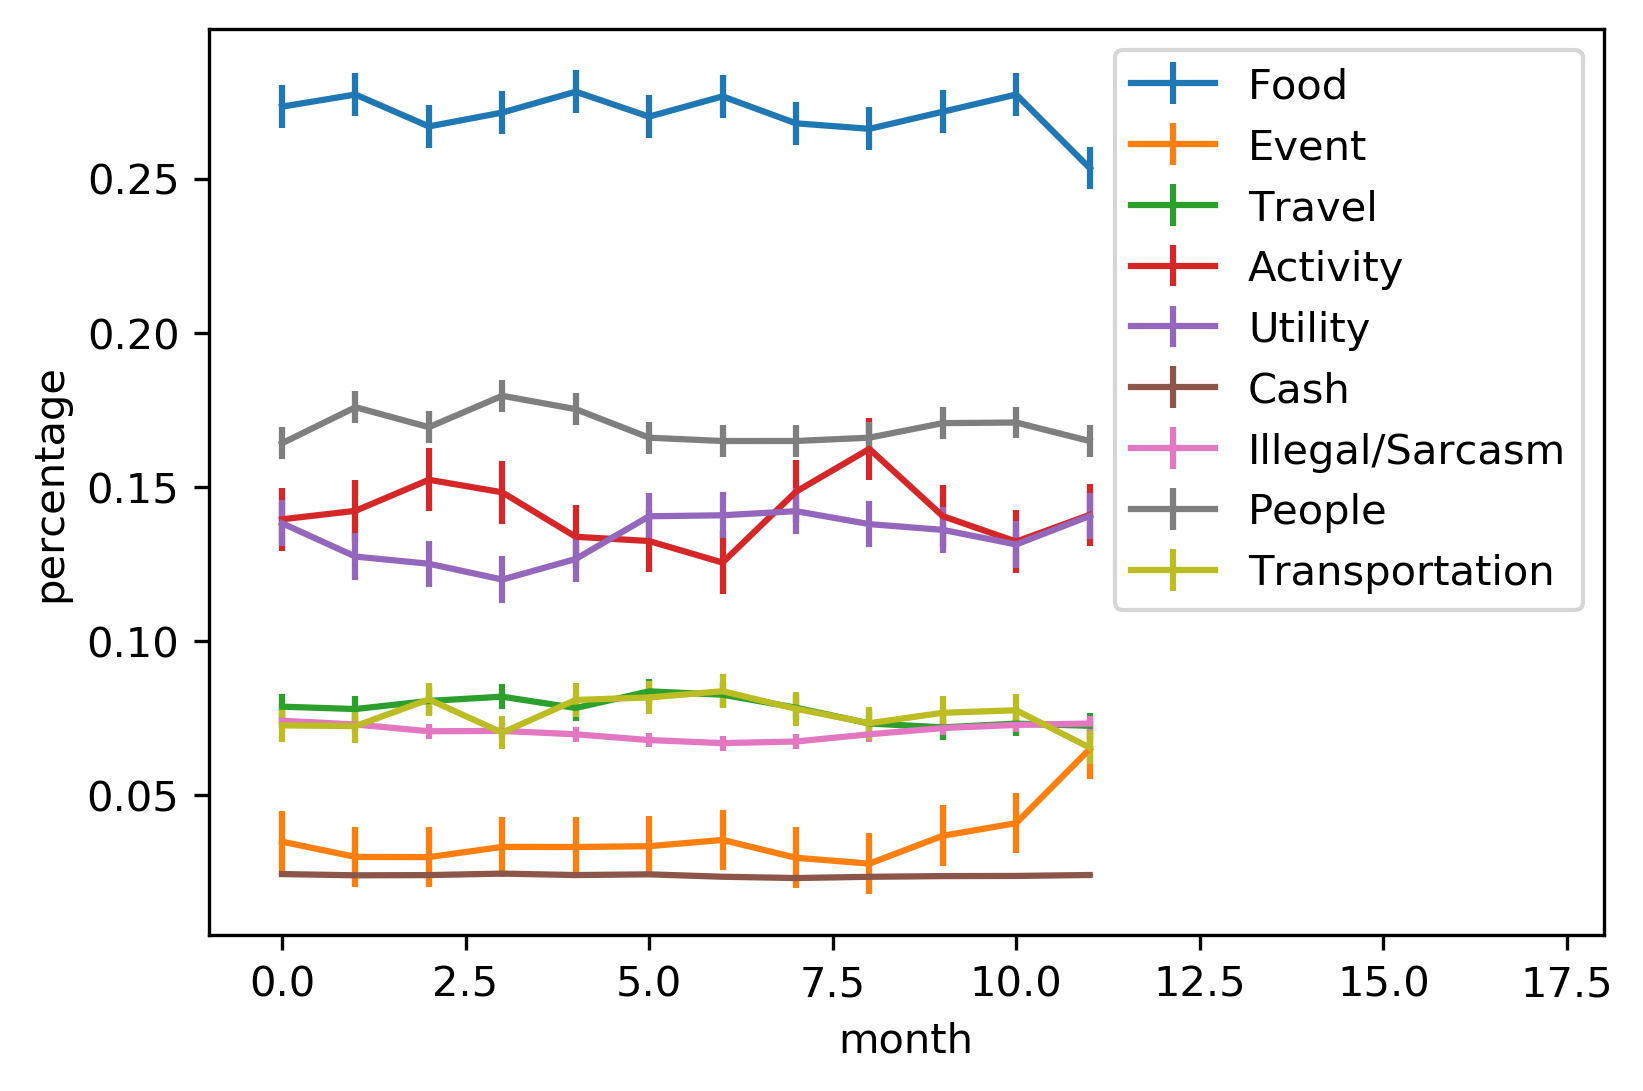

In [0]:
import matplotlib.pyplot as plt  
%matplotlib inline
plt.figure(dpi=300)
for p in plot_data:
    plt.errorbar(x=list(range(len(p.mean_values))) ,y=p.mean_values, yerr=p.stddev_value, label=p.key)
plt.xlabel('month')
plt.ylabel('percentage')
plt.xlim(-1, 18)
plt.legend()
plt.show()

What do you observe? Does the spending profile of the average customer stabilize after some point in time?

Nothing observed.No, it does not stabilize.

# Social Network Analytics

## Q5: find a user’s friends and friends of friends

### user’s friends

- `fou1` stands for *friends of user1*
- `fou2` stands for *friends of user2*

In [0]:
send_money_friends = practice_clsed.select("user1", "user2").groupBy("user1").agg(collect_set("user2").alias("fou1"))
send_money_friends.show()

+-----+--------------------+
|user1|                fou1|
+-----+--------------------+
| 2866|             [30588]|
| 6620|        [6507, 6606]|
|28170|             [27438]|
|28759|     [397277, 65628]|
|29894|             [33385]|
|33602|[4292661, 152043,...|
|36525|     [192549, 28192]|
|47283|             [50233]|
|51415|[102073, 140312, ...|
|53963|           [4463238]|
|59990|            [178013]|
|63087|     [62361, 100977]|
|64423|             [64350]|
|65408|             [61673]|
|67492|[112657, 1557924,...|
|67861|     [81602, 208855]|
|68202|           [2174691]|
|71995|           [1415933]|
|72758|            [158969]|
|74775|[422868, 127713, ...|
+-----+--------------------+
only showing top 20 rows



In [0]:
receive_money_friends = practice_clsed.select("user1", "user2").groupBy("user2").agg(collect_set("user1").alias("fou2"))
receive_money_friends.show()
receive_money_friends.printSchema()

+-----+--------------------+
|user2|                fou2|
+-----+--------------------+
| 3918|           [7219365]|
| 4935|             [26952]|
| 5300|[3471989, 6881591...|
|20735|      [98941, 76245]|
|28170|[4597539, 687334,...|
|28759|            [581923]|
|29054|  [2153890, 3457112]|
|29894|           [2787407]|
|30903|[2032414, 852163,...|
|30970|           [1364887]|
|32396|            [322255]|
|35820|           [1012471]|
|36525|            [192549]|
|40653|   [894165, 1117591]|
|43714|[708720, 519127, ...|
|43935|[4076961, 1906041...|
|44022|           [1660128]|
|44358|            [540426]|
|44822|     [265792, 63997]|
|45615|   [2328872, 179985]|
+-----+--------------------+
only showing top 20 rows

root
 |-- user2: integer (nullable = true)
 |-- fou2: array (nullable = true)
 |    |-- element: integer (containsNull = true)



join friends

In [0]:
@udf(returnType="array<integer>")
def udfMergeFriends(f1, f2):
    if f1 is None:
        return f2
    elif f2 is None:
        return f1
    else:
        r = []
        r.extend(f1)
        r.extend(f2)
        return r

In [0]:
user_friends = send_money_friends.join(receive_money_friends, send_money_friends.user1 == receive_money_friends.user2, "full")\
    .select(coalesce("user1", "user2").alias("user"), udfMergeFriends(col("fou1"), col("fou2")).alias("friends"))

In [0]:
user_friends.show()

+-----+--------------------+
| user|             friends|
+-----+--------------------+
| 2866|             [30588]|
| 3918|           [7219365]|
| 4935|             [26952]|
| 5300|[3471989, 6881591...|
| 6620|        [6507, 6606]|
|20735|      [98941, 76245]|
|28170|[27438, 4597539, ...|
|28759|[397277, 65628, 5...|
|29054|  [2153890, 3457112]|
|29894|    [33385, 2787407]|
|30903|[2032414, 852163,...|
|30970|           [1364887]|
|32396|            [322255]|
|33602|[4292661, 152043,...|
|35820|           [1012471]|
|36525|[192549, 28192, 1...|
|40653|   [894165, 1117591]|
|43714|[708720, 519127, ...|
|43935|[4076961, 1906041...|
|44022|           [1660128]|
+-----+--------------------+
only showing top 20 rows



### friends of friends

explore `friends` again to calculate friends of friends

In [0]:
user_friend = user_friends.select("user", explode("friends").alias("friend")).cache()

In [0]:
user_friend.show()

+-----+-------+
| user| friend|
+-----+-------+
| 2866|  30588|
| 3918|7219365|
| 4935|  26952|
| 5300|3471989|
| 5300|6881591|
| 5300|4137286|
| 5300|1682861|
| 6620|   6507|
| 6620|   6606|
|20735|  98941|
|20735|  76245|
|28170|  27438|
|28170|4597539|
|28170| 687334|
|28170| 368813|
|28759| 397277|
|28759|  65628|
|28759| 581923|
|29054|2153890|
|29054|3457112|
+-----+-------+
only showing top 20 rows



In [0]:
user_f_fs = user_friend.alias("a").join(user_friends.alias("b"), col("a.friend") == col("b.user"), "full")\
    .drop(col("b.user")).cache()

merge map

In [0]:
@udf(returnType="map<int, array<int>>")
def udfFlattenMap(array_of_map):
    r ={}
    for m in array_of_map:
        r.update(m)
    return r

`ftofof` stands for "friends to friends of friends" map

In [0]:
user_ftofof = user_f_fs.withColumn("relationship", create_map(col("friend"), col("friends")))\
    .groupBy("user")\
    .agg(udfFlattenMap(collect_list("relationship")).alias("ftofof"))

In [0]:
user_ftofof.show(truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user |ftofof                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

## Q6:

### i) Number of friends and number of friends of friends

In [0]:
@udf(returnType="map<int, int>")
def udfCalcNOFF(ftofof):
    return dict(map(lambda x: (x[0], len(x[1])), ftofof.items()))

In [0]:
@udf(returnType="int")
def udfCalcTNOFF(ftofof):
    i = 0
    for k, v in ftofof.items():
        i += len(v)
    return i

- `nof` stands for *number of friends*
- `noff` stands for *number of friends of friends*
- `tnoff` stands for *total number of friends of friends*

In [0]:
number_of_user = user_ftofof.withColumn("nof", size("ftofof"))\
    .withColumn("noff", udfCalcNOFF(col("ftofof")))\
    .withColumn("tnoff", udfCalcTNOFF(col("ftofof"))).cache()

In [0]:
number_of_user.show()

+-----+--------------------+---+--------------------+-----+
| user|              ftofof|nof|                noff|tnoff|
+-----+--------------------+---+--------------------+-----+
| 2866|   [30588 -> [2866]]|  1|        [30588 -> 1]|    1|
| 3918| [7219365 -> [3918]]|  1|      [7219365 -> 1]|    1|
| 4935|[26952 -> [158652...|  1|        [26952 -> 8]|    8|
| 5300|[3471989 -> [1318...|  4|[3471989 -> 6, 41...|   10|
| 6620|[6606 -> [21263, ...|  2|[6606 -> 8, 6507 ...|   11|
|20735|[76245 -> [20735,...|  2|[76245 -> 5, 9894...|    6|
|28170|[368813 -> [60286...|  4|[368813 -> 6, 687...|   14|
|28759|[581923 -> [14352...|  3|[397277 -> 11, 58...|   32|
|29054|[3457112 -> [2905...|  2|[3457112 -> 1, 21...|    3|
|29894|[2787407 -> [2989...|  2|[2787407 -> 2, 33...|    8|
|30903|[2032414 -> [8493...|  4|[593848 -> 5, 203...|   24|
|30970|[1364887 -> [1006...|  1|     [1364887 -> 10]|   10|
|32396|[322255 -> [32396...|  1|       [322255 -> 4]|    4|
|33602|[677386 -> [33602...|  4|[677386 

### ii) Clustering coefficient of a user's network

`cc` stands for *Clustering coefficient*

In [0]:
@udf(returnType="double")
def udfCalcCC(nof, ftofof):
    if nof <= 1:
        return 0.0
    nv = 0.0
    my_friends = ftofof.keys()
    for friend, friends_of_friend in ftofof.items():
        nv += len(set(my_friends) & set(friends_of_friend))
    cc = 2 * nv / (nof * (nof - 1))
    return cc

In [0]:
number_of_user = number_of_user.withColumn("cc", udfCalcCC(col("nof"), col("ftofof")))
number_of_user.show()

+-----+--------------------+---+--------------------+-----+------------------+
| user|              ftofof|nof|                noff|tnoff|                cc|
+-----+--------------------+---+--------------------+-----+------------------+
| 2866|   [30588 -> [2866]]|  1|        [30588 -> 1]|    1|               0.0|
| 3918| [7219365 -> [3918]]|  1|      [7219365 -> 1]|    1|               0.0|
| 4935|[26952 -> [158652...|  1|        [26952 -> 8]|    8|               0.0|
| 5300|[3471989 -> [1318...|  4|[3471989 -> 6, 41...|   10|               0.0|
| 6620|[6606 -> [21263, ...|  2|[6606 -> 8, 6507 ...|   11|               0.0|
|20735|[76245 -> [20735,...|  2|[76245 -> 5, 9894...|    6|               0.0|
|28170|[368813 -> [60286...|  4|[368813 -> 6, 687...|   14|0.3333333333333333|
|28759|[581923 -> [14352...|  3|[397277 -> 11, 58...|   32|               0.0|
|29054|[3457112 -> [2905...|  2|[3457112 -> 1, 21...|    3|               0.0|
|29894|[2787407 -> [2989...|  2|[2787407 -> 2, 33...

### iii) Calculate the page rank of each user

there is no GraphX available for pyspark, so use GraphFrames instead

build edges and vertices for graph

In [0]:
e = user_friend.withColumnRenamed("user", "src").withColumnRenamed("friend", "dst")
e.write.parquet("./edges.parquet")

In [0]:
srcs = e.select(e.src.alias("id"))
dsts = e.select(e.dst.alias("id"))
v = srcs.unionAll(dsts).distinct()
v.write.parquet("./vertices.parquet")

In [0]:
e = spark.read.parquet("./edges.parquet").cache()

In [0]:
v = spark.read.parquet("./vertices.parquet").cache()

In [0]:
from graphframes import *
g = GraphFrame(v, e)

In [0]:
sc.setCheckpointDir("./ckpt")

In [0]:
# Run PageRank
results = g.pageRank(resetProbability=0.15, maxIter=100)

In [0]:
# Display resulting pageranks and final edge weights
results.vertices.write.parquet("./pagerank_result_100.parquet")

In [0]:
practice_pagerank = results.vertices

In [0]:
practice_pagerank.show()

+-----+-------------------+
|   id|           pagerank|
+-----+-------------------+
|   29| 0.7378334354692134|
|  964|0.34195027717261695|
| 1697|  1.842110576389695|
| 2509| 0.6029373983655516|
| 3506| 0.6601353638590045|
| 4894| 0.3561035597638667|
| 5556| 0.9999999999999044|
| 6721| 0.3224956694235325|
|21209| 1.1333103359070409|
|27255|  0.951976667624201|
|27919| 0.7874913784391356|
|29824| 0.9847706999718389|
|32098|0.32081860138671914|
|33862| 0.5195056474442958|
|34821| 0.5337403223216596|
|35253| 0.9999999999999044|
|37282|  1.802940116501576|
|37884| 0.4964300811841002|
|38108|  3.412353589651712|
|38287|  0.920686054023714|
+-----+-------------------+
only showing top 20 rows



# Predictive Analytics with MLlib

## Q7: for every user, count how many transactions s/he had committed during her/his twelve months in practice

In [0]:
user1_Y = practice_clsed.withColumn("year", year("datetime"))\
    .withColumn("month", month("datetime"))\
    .groupBy("user1", "year", "month")\
    .count()\
    .withColumnRenamed("count", "Y")\
    .sort("user1", "year", "month")\
    .groupBy("user1", "month")\
    .agg(first("year").alias("first_year"), first("Y").alias("Y"))\
    .select("user1", "month", "Y")\
    .cache()

In [0]:
user1_Y.sort("user1").show()

+-----+-----+---+
|user1|month|  Y|
+-----+-----+---+
|    2|   11|  1|
|    3|   10|  5|
|    3|    9|  1|
|    4|    4|  1|
|    4|    2|  1|
|    4|    3|  1|
|    4|    6|  1|
|    4|   12|  2|
|   10|    3|  2|
|   10|    4|  1|
|   10|    1|  1|
|   10|   12|  2|
|   10|   11|  1|
|   11|   10|  2|
|   11|    8|  2|
|   11|   12|  3|
|   11|    4|  1|
|   11|   11|  1|
|   11|    5|  1|
|   11|    6|  3|
+-----+-----+---+
only showing top 20 rows



## Q8: Create the recency and frequency variables

In [0]:
user1_r_f = practice_clsed.groupBy("user1")\
    .agg(datediff(current_date(), max("datetime")).alias("recency"), (datediff(max("datetime"), min("datetime")) / count("user1")).alias("frequency"))
user1_r_f.show()

+-------+-------+------------------+
|  user1|recency|         frequency|
+-------+-------+------------------+
|1178368|   1417| 95.66666666666667|
|2343603|   1366| 64.55555555555556|
|2735011|   1340|               0.0|
|2561172|   1366|              83.4|
|4850289|   1638|15.333333333333334|
|3650349|   1407|               4.0|
|1875359|   1395|172.66666666666666|
| 336620|   1286|63.166666666666664|
| 974353|   1476|             168.0|
|1596435|   1343|             160.4|
|8820719|   1501|              18.5|
|1255557|   1482| 67.81818181818181|
|2602983|   1312| 66.33333333333333|
|1153913|   1537|             240.5|
|1488007|   1527|              36.6|
|1652830|   1589| 47.77777777777778|
| 794130|   1439| 46.72222222222222|
|3499717|   1801|               0.0|
|2961147|   1364|              96.0|
|2401136|   1300|            66.375|
+-------+-------+------------------+
only showing top 20 rows



## Q9: regress recency and frequency on Y

In [0]:
from pyspark.ml.feature import VectorAssembler

vectorAssemblerFeatures = VectorAssembler(
    inputCols=["recency", "frequency"],
    outputCol="features"
)

In [0]:
from pyspark.ml.regression import LinearRegression

In [0]:
lr = LinearRegression(maxIter=20, labelCol="Y")

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="Y", predictionCol="prediction", metricName="mse")

In [0]:
mses = []

In [0]:
for i in range(1, 13):
    print(f"for month {i}")
    regress_dataset_month = user1_Y.filter(col("month") == i).join(user1_r_f, "user1", "left")
    regress_dataset_with_feature = vectorAssemblerFeatures.transform(regress_dataset_month)
    test_set, train_set = regress_dataset_with_feature.randomSplit([0.2, 0.8])
    
    model = lr.fit(train_set)
    prediction = model.transform(test_set)

    # Mean Square Error
    mse = eval.evaluate(prediction, {eval.metricName: "mse"})
    print("MSE: %.3f" % mse)
    mses.append(mse)

for month 1
MSE: 0.228
for month 2
MSE: 0.231
for month 3
MSE: 0.259
for month 4
MSE: 0.262
for month 5
MSE: 0.253
for month 6
MSE: 0.222
for month 7
MSE: 0.210
for month 8
MSE: 0.195
for month 9
MSE: 0.219
for month 10
MSE: 0.223
for month 11
MSE: 0.210
for month 12
MSE: 0.184


In [0]:
mses

[0.22829247892265733,
 0.23117562928184832,
 0.2594616549608055,
 0.2622611028502224,
 0.2527498145964329,
 0.22232966797058695,
 0.20985688738489322,
 0.19517449256816388,
 0.21885880107899372,
 0.22344581835404814,
 0.2095081759369257,
 0.1842727324409782]

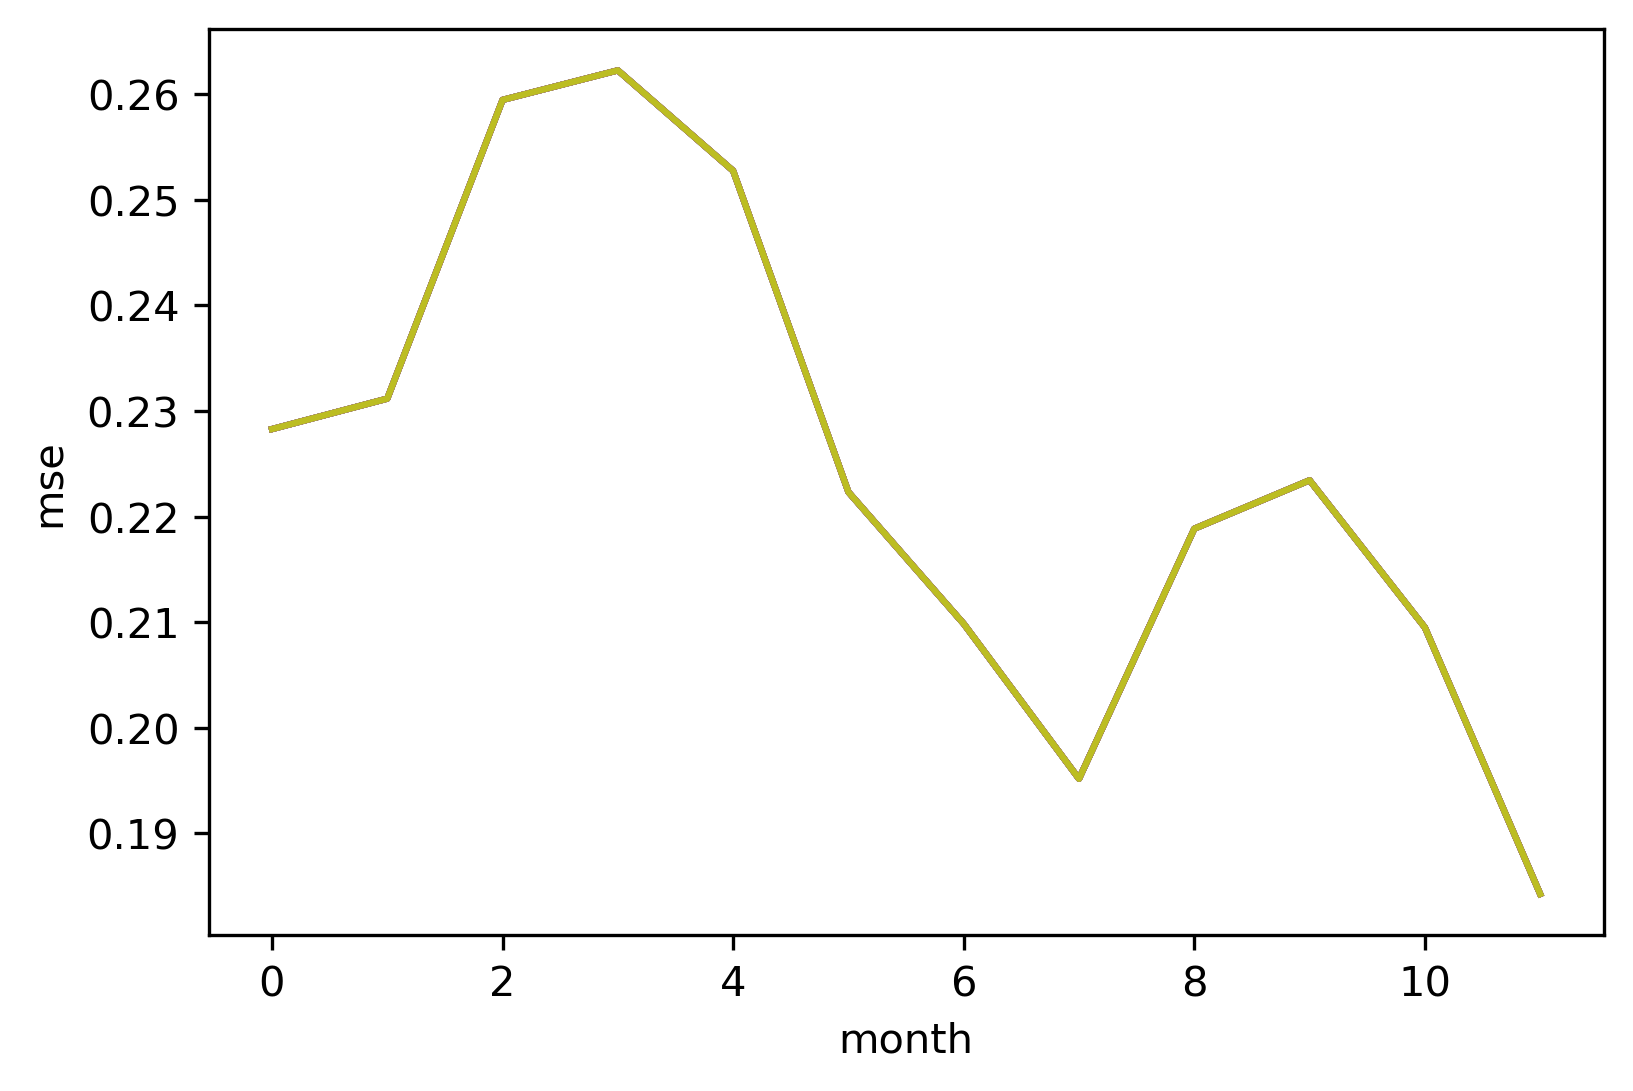

In [0]:
plt.figure(dpi=300)
for p in plot_data:
    plt.plot(mses)
plt.xlabel('month')
plt.ylabel('mse')
plt.show()

## Q10

In [0]:
user1MonthDSP_first_year_feature = user1MonthDSP_first_year.withColumn("People", col("dynamic_spending_profile")["People"])\
    .withColumn("Food", col("dynamic_spending_profile")["Food"])\
    .withColumn("Event", col("dynamic_spending_profile")["Event"])\
    .withColumn("Activity", col("dynamic_spending_profile")["Activity"])\
    .withColumn("Travel", col("dynamic_spending_profile")["Travel"])\
    .withColumn("Transportation", col("dynamic_spending_profile")["Transportation"])\
    .withColumn("Utility", col("dynamic_spending_profile")["Utility"])\
    .withColumn("Cash", col("dynamic_spending_profile")["Cash"])\
    .withColumn("Illegal/Sarcasm", col("dynamic_spending_profile")["Illegal/Sarcasm"])\
    .na.fill(0.0)

In [0]:
user1MonthDSP_first_year_feature.show()

+-----+-----+------------------------+------------------+----+-----+--------+------------------+--------------+-------+----+---------------+
|user1|month|dynamic_spending_profile|            People|Food|Event|Activity|            Travel|Transportation|Utility|Cash|Illegal/Sarcasm|
+-----+-----+------------------------+------------------+----+-----+--------+------------------+--------------+-------+----+---------------+
|    2|   11|           [Cash -> 1.0]|               0.0| 0.0|  0.0|     0.0|               0.0|           0.0|    0.0| 1.0|            0.0|
|    3|   10|    [People -> 0.25, ...|              0.25| 0.0| 0.25|     0.0|               0.5|           0.0|    0.0| 0.0|            0.0|
|    3|    9|         [People -> 1.0]|               1.0| 0.0|  0.0|     0.0|               0.0|           0.0|    0.0| 0.0|            0.0|
|    4|    3|         [Travel -> 1.0]|               0.0| 0.0|  0.0|     0.0|               1.0|           0.0|    0.0| 0.0|            0.0|
|    4|    6|

In [0]:
mses4q10 = []

In [0]:
vectorAssemblerFeatures = VectorAssembler(
    inputCols=["recency", "frequency", "People", "Food", "Event", "Activity", "Travel", "Transportation", "Utility", "Cash", "Illegal/Sarcasm"],
    outputCol="features"
)

for i in range(1, 13):
    print(f"for month {i}")
    regress_dataset_month = user1_Y.filter(col("month") == i).join(user1_r_f, "user1", "left")\
        .join(user1MonthDSP_first_year_feature, "user1", "inner")
    regress_dataset_with_feature = vectorAssemblerFeatures.transform(regress_dataset_month)
    test_set, train_set = regress_dataset_with_feature.randomSplit([0.2, 0.8])
    
    model = lr.fit(train_set)
    prediction = model.transform(test_set)

    # Mean Square Error
    mse = eval.evaluate(prediction, {eval.metricName: "mse"})
    print("MSE: %.3f" % mse)
    mses4q10.append(mse)

for month 1
MSE: 0.343
for month 2
MSE: 0.335
for month 3
MSE: 0.367
for month 4
MSE: 0.379
for month 5
MSE: 0.367
for month 6
MSE: 0.319
for month 7
MSE: 0.311
for month 8
MSE: 0.337
for month 9
MSE: 0.315
for month 10
MSE: 0.313
for month 11
MSE: 0.307
for month 12
MSE: 0.268


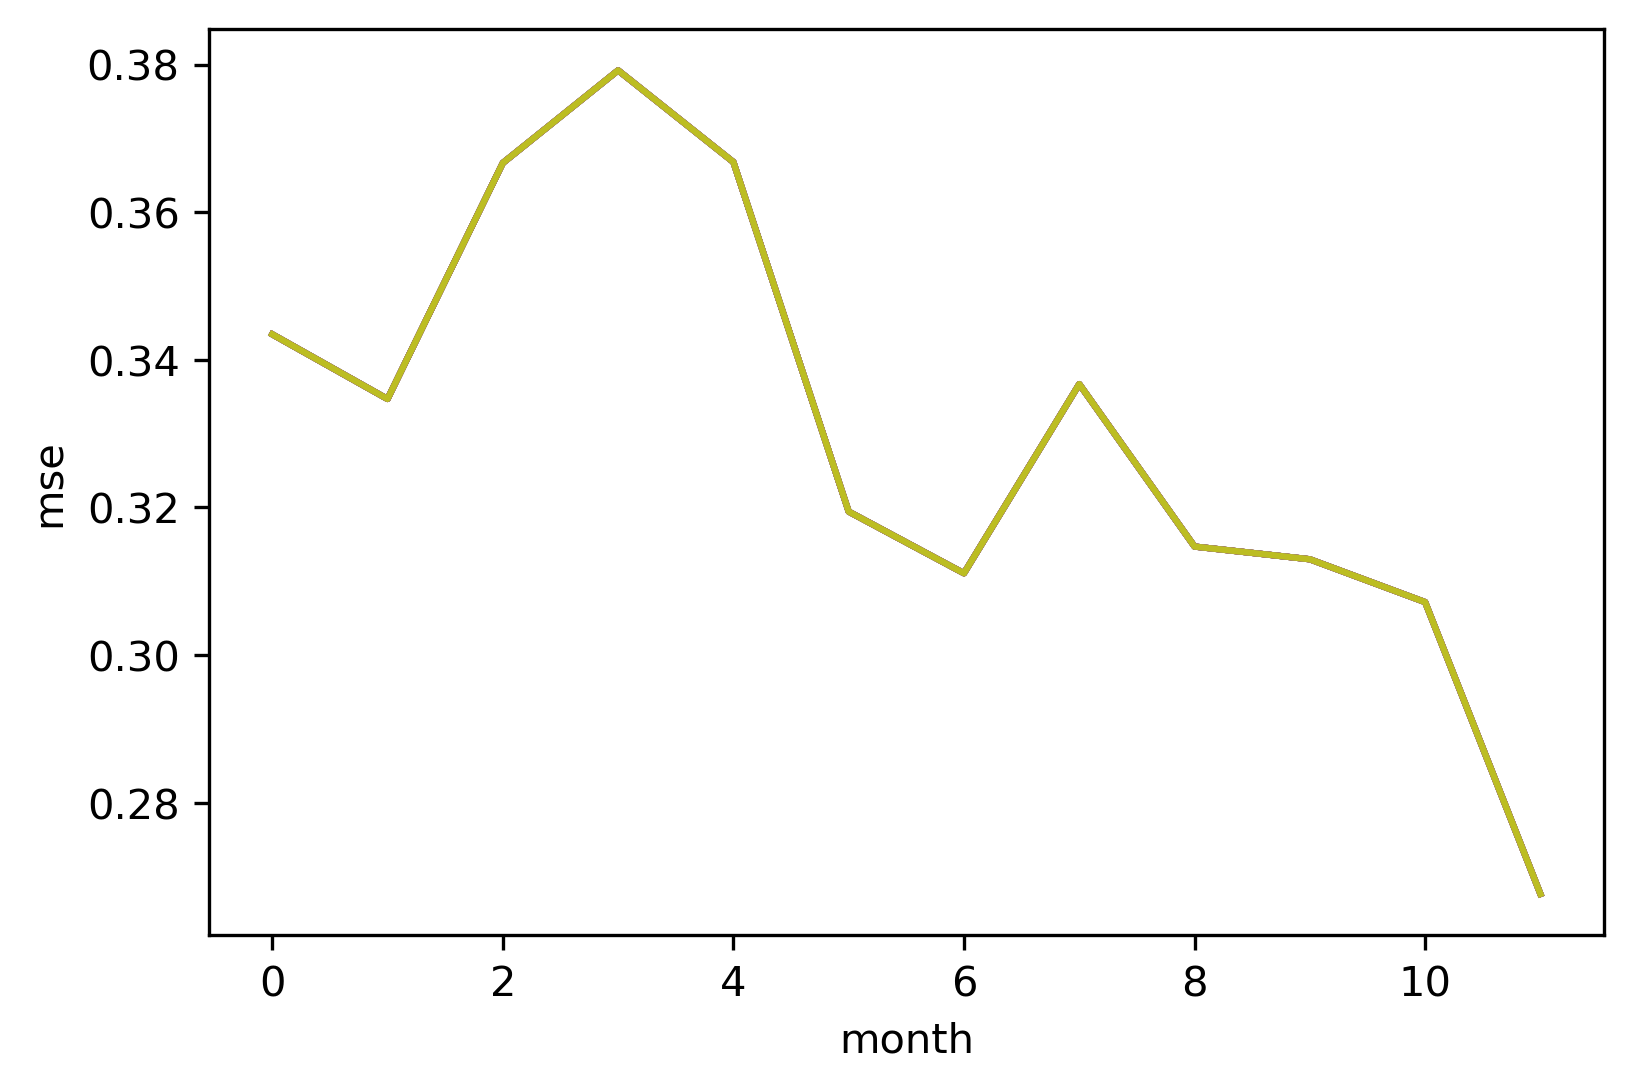

In [0]:
plt.figure(dpi=300)
for p in plot_data:
    plt.plot(mses4q10)
plt.xlabel('month')
plt.ylabel('mse')
plt.show()

### Q10 regress her social network metrics on ​ Y

In [0]:
number_of_user.show()

+-----+--------------------+---+--------------------+-----+------------------+
| user|              ftofof|nof|                noff|tnoff|                cc|
+-----+--------------------+---+--------------------+-----+------------------+
| 2866|   [30588 -> [2866]]|  1|        [30588 -> 1]|    1|               0.0|
| 3918| [7219365 -> [3918]]|  1|      [7219365 -> 1]|    1|               0.0|
| 4935|[26952 -> [158652...|  1|        [26952 -> 8]|    8|               0.0|
| 5300|[3471989 -> [1318...|  4|[3471989 -> 6, 41...|   10|               0.0|
| 6620|[6606 -> [21263, ...|  2|[6606 -> 8, 6507 ...|   11|               0.0|
|20735|[76245 -> [20735,...|  2|[76245 -> 5, 9894...|    6|               0.0|
|28170|[368813 -> [60286...|  4|[368813 -> 6, 687...|   14|0.3333333333333333|
|28759|[581923 -> [14352...|  3|[397277 -> 11, 58...|   32|               0.0|
|29054|[3457112 -> [2905...|  2|[3457112 -> 1, 21...|    3|               0.0|
|29894|[2787407 -> [2989...|  2|[2787407 -> 2, 33...

In [0]:
practice_pagerank = spark.read.parquet("./pagerank_result_100.parquet")

In [0]:
practice_pagerank.show()

+-----+-------------------+
|   id|           pagerank|
+-----+-------------------+
|  879|  3.555750242987126|
| 1296| 0.5082315352795299|
| 2482| 1.8459117763636042|
| 2952| 1.4594594192673056|
| 3277| 0.6729164293796234|
| 4653| 2.4171050681557222|
| 6232| 0.3519019940877574|
|21942|0.37443842070425365|
|24543| 1.4921511623015877|
|34560|  0.748687016058609|
|35256| 0.4113153650186493|
|35382|  4.587775316973527|
|39678| 0.9999999999999044|
|40236|  1.129829471924829|
|41688| 1.3755441120686678|
|41752| 0.7733974736193172|
|42673| 0.8596739982510019|
|43570| 1.8775697406442051|
|44351| 0.4779815503483518|
|44988| 0.5093102588272564|
+-----+-------------------+
only showing top 20 rows



In [0]:
social_network_metrics = number_of_user.join(practice_pagerank, number_of_user.user == practice_pagerank.id, "full").na.fill(0.0).cache()

In [0]:
social_network_metrics.show()

+-----+--------------------+---+--------------------+-----+------------------+-----+-------------------+
| user|              ftofof|nof|                noff|tnoff|                cc|   id|           pagerank|
+-----+--------------------+---+--------------------+-----+------------------+-----+-------------------+
| 2866|   [30588 -> [2866]]|  1|        [30588 -> 1]|    1|               0.0| 2866| 0.9999999999999044|
| 3918| [7219365 -> [3918]]|  1|      [7219365 -> 1]|    1|               0.0| 3918| 0.9999999999999044|
| 4935|[26952 -> [158652...|  1|        [26952 -> 8]|    8|               0.0| 4935| 0.5028451398729509|
| 5300|[3471989 -> [1318...|  4|[3471989 -> 6, 41...|   10|               0.0| 5300|  1.426354914407972|
| 6620|[6606 -> [21263, ...|  2|[6606 -> 8, 6507 ...|   11|               0.0| 6620| 0.8305350415219904|
|20735|[76245 -> [20735,...|  2|[76245 -> 5, 9894...|    6|               0.0|20735| 0.7316854411692769|
|28170|[368813 -> [60286...|  4|[368813 -> 6, 687...|  

In [0]:
mses4q102 = []

In [0]:
vectorAssemblerFeatures = VectorAssembler(
    inputCols=["nof", "tnoff", "cc", "pagerank"],
    outputCol="features"
)

for i in range(1, 13):
    print(f"for month {i}")
    user1_Y_monthi = user1_Y.filter(col("month") == i)
    regress_dataset_month = user1_Y_monthi.join(social_network_metrics, user1_Y_monthi.user1 == social_network_metrics.user, "left")
    regress_dataset_with_feature = vectorAssemblerFeatures.transform(regress_dataset_month)
    test_set, train_set = regress_dataset_with_feature.randomSplit([0.2, 0.8])
    
    model = lr.fit(train_set)
    prediction = model.transform(test_set)

    # Mean Square Error
    mse = eval.evaluate(prediction, {eval.metricName: "mse"})
    print("MSE: %.3f" % mse)
    mses4q102.append(mse)

for month 1
MSE: 0.215
for month 2
MSE: 0.232
for month 3
MSE: 0.255
for month 4
MSE: 0.251
for month 5
MSE: 0.239
for month 6
MSE: 0.201
for month 7
MSE: 0.209
for month 8
MSE: 0.190
for month 9
MSE: 0.218
for month 10
MSE: 0.207
for month 11
MSE: 0.204
for month 12
MSE: 0.177


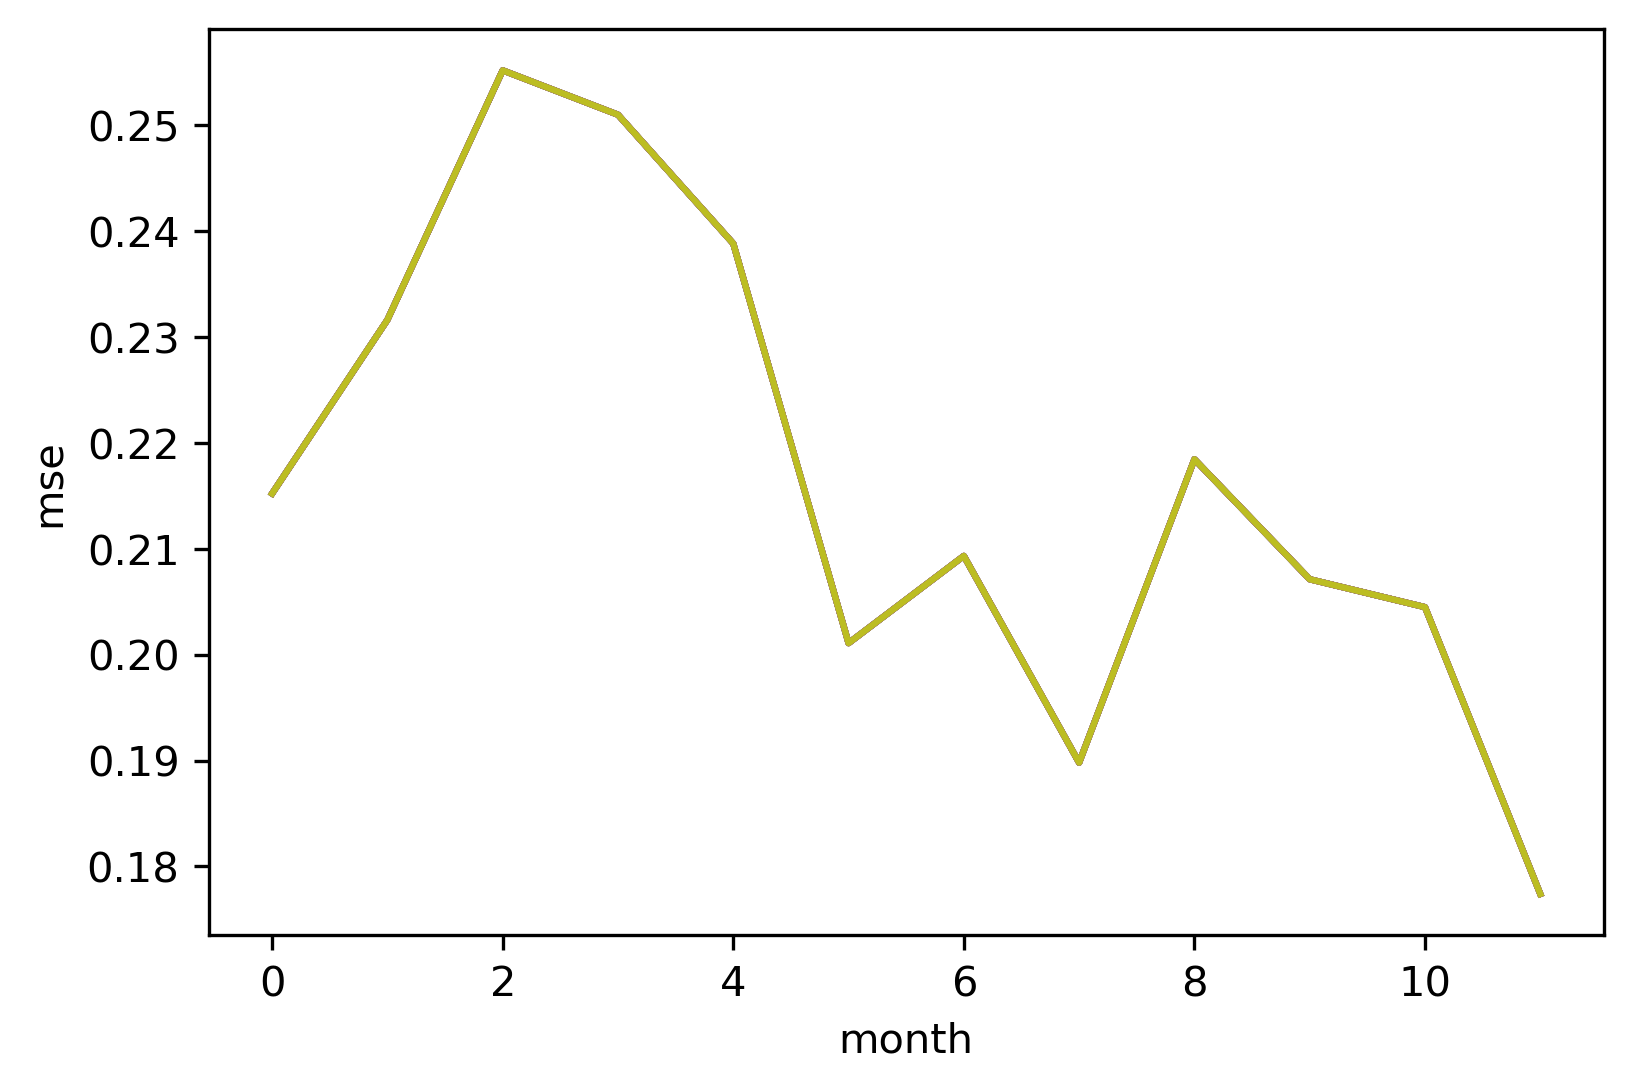

In [0]:
plt.figure(dpi=300)
for p in plot_data:
    plt.plot(mses4q102)
plt.xlabel('month')
plt.ylabel('mse')
plt.show()

### Q11: regress her social network metrics  and the spending behavior

In [0]:
mses4q11 = []

In [0]:
vectorAssemblerFeatures = VectorAssembler(
    inputCols=["nof", "tnoff", "cc", "pagerank", "People", "Food", "Event", "Activity", "Travel", "Transportation", "Utility", "Cash", "Illegal/Sarcasm"],
    outputCol="features"
)

for i in range(1, 13):
    print(f"for month {i}")
    user1_Y_monthi = user1_Y.filter(col("month") == i)
    regress_dataset_month = user1_Y_monthi.join(social_network_metrics, user1_Y_monthi.user1 == social_network_metrics.user, "left")\
         .join(user1MonthDSP_first_year_feature, "user1", "inner")
    regress_dataset_with_feature = vectorAssemblerFeatures.transform(regress_dataset_month)
    test_set, train_set = regress_dataset_with_feature.randomSplit([0.2, 0.8])
    
    model = lr.fit(train_set)
    prediction = model.transform(test_set)

    # Mean Square Error
    mse = eval.evaluate(prediction, {eval.metricName: "mse"})
    print("MSE: %.3f" % mse)
    mses4q11.append(mse)

for month 1
MSE: 0.332
for month 2
MSE: 0.336
for month 3
MSE: 0.369
for month 4
MSE: 0.375
for month 5
MSE: 0.358
for month 6
MSE: 0.309
for month 7
MSE: 0.303
for month 8
MSE: 0.308
for month 9
MSE: 0.309
for month 10
MSE: 0.308
for month 11
MSE: 0.321
for month 12
MSE: 0.268


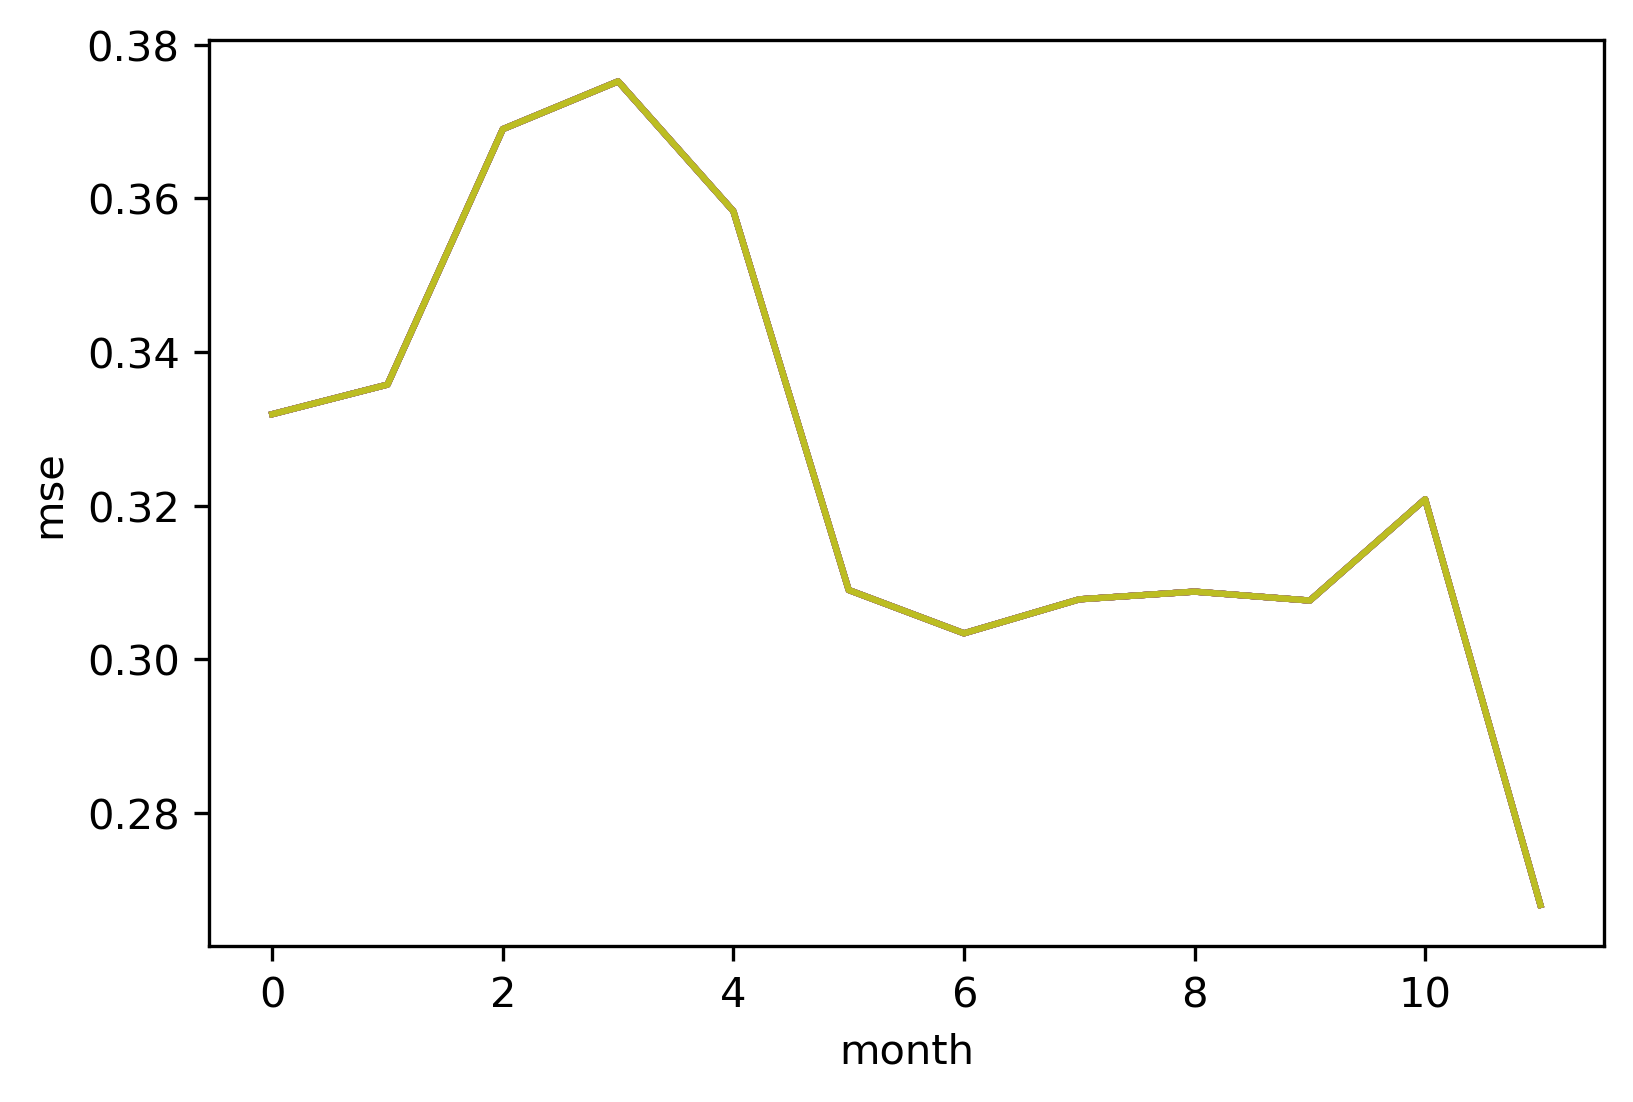

In [0]:
plt.figure(dpi=300)
for p in plot_data:
    plt.plot(mses4q11)
plt.xlabel('month')
plt.ylabel('mse')
plt.show()